## MNIST logistic regression in TensorFlow

Code based on: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/logistic_regression.py

In [38]:
import sys
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading functions

In [2]:
# courtesy of f0k:
# https://gist.github.com/f0k/738fa2eedd9666b78404ed1751336f56
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [39]:
X_train, y_train, X_val, y_val, _, _ = load_dataset()

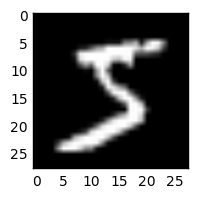

In [59]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[0][0], cmap="gray")

In [65]:
def label_to_one_hot(y_mat, num_classes=10):
    one_hots = np.zeros((y_mat.shape[0], num_classes))
    for i in range(one_hots.shape[0]):
        one_hots[i][y_mat[i]] = 1.
    return one_hots

The original input is in the form of (bs, 1, 28, 28), but since we're not using conv-nets, we want to flatten this into a 28*28 = 784 vector. So let's do that here. Let's also convert the labels to one-hot representations.

In [88]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_val = X_val.reshape((X_val.shape[0], 28*28))
y_train_onehot = label_to_one_hot(y_train)
y_val_onehot = label_to_one_hot(y_val)

In [82]:
def iterator(X_mat, y_mat, bs, shuffle):
    """
    Mini-batch iterator for the data
    X_mat: X data
    y_mat: y data
    bs: batch size
    shuffle: pre-shuffle the data before iterating?
    """
    if shuffle:
        idxs = [x for x in range(X_mat.shape[0])]
        X_mat, y_mat = X_mat[idxs], y_mat[idxs]
    b = 0
    while True:
        if b*bs >= X_mat.shape[0]:
            break
        yield X_mat[b*bs:(b+1)*bs], y_mat[b*bs:(b+1)*bs]
        b += 1

### Graph setup

In [21]:
x = tf.placeholder(dtype=tf.float32, shape=(None, 784))
y = tf.placeholder(dtype=tf.float32, shape=(None, 10))

In [22]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

It seems like -- unlike Theano -- to view these variables you have to run them within a 'session'. This also seems to imply that once the session finishes the variables are lost and go back to being 'unitialised'?

In [37]:
with tf.Session() as sess:
    sess.run(W.initializer)
    sess.run(b.initializer)
    print sess.run(W)
    print sess.run(b)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


`tf.initialize_all_variables()` is a helper function that initialises all of these variables.

$$ f(\mathbf{x}) = softmax( \mathbf{x}\mathbf{W} + \mathbf{b} )$$

In [69]:
preds = tf.nn.softmax( tf.add(tf.matmul(x,W), b) )

In [70]:
preds.shape

TensorShape([Dimension(None), Dimension(10)])

We wish to minimise the loss over all (x,y):

$$ \sum_{i=1}^{k} y_{i} \ log \ p(y|x)_{i}$$

In [75]:
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(preds), reduction_indices=1))

In [80]:
learning_rate = 0.01
optimiser = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [98]:
init = tf.initialize_all_variables()
num_epochs = 10
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        train_losses, valid_losses = [], []
        for X_batch, y_batch in iterator(X_train, y_train_onehot, bs=32, shuffle=True):
            _, c = sess.run([optimiser, cost], feed_dict={x: X_batch, y: y_batch})
            train_losses.append(c)
        for X_batch, y_batch in iterator(X_val, y_val_onehot, bs=32, shuffle=False):
            _, c, valid_preds = sess.run([optimiser, cost, preds], feed_dict={x: X_batch, y: y_batch})
            valid_losses.append(c)
        print "epoch = %i, train loss = %f, valid loss = %f" % (epoch+1, np.mean(train_losses), np.mean(valid_losses))
    # we now want to save the model
    saver = tf.train.Saver()
    saver.save(sess, 'my_model')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch = 1, train loss = 0.824304, valid loss = 0.472991
epoch = 2, train loss = 0.466413, valid loss = 0.387426
epoch = 3, train loss = 0.410850, valid loss = 0.354316
epoch = 4, train loss = 0.383362, valid loss = 0.335521
epoch = 5, train loss = 0.366076, valid loss = 0.322951
epoch = 6, train loss = 0.353871, valid loss = 0.313740
epoch = 7, train loss = 0.344639, valid loss = 0.306589
epoch = 8, train loss = 0.337328, valid loss = 0.300811
epoch = 9, train loss = 0.331345, valid loss = 0.296005
epoch = 10, train loss = 0.326328, valid loss = 0.291920


Unless you use an interactive session, once the session is over, everything is gone. So if you are running this in a non-interactive context (i.e., a regular Python script), you want to save your model using the `tf.train.Saver()` class and reload it when you open up another session.

In [100]:
%%bash
ls my_model*

my_model.data-00000-of-00001
my_model.index
my_model.meta


In [105]:
%%bash
cat checkpoint

model_checkpoint_path: "my_model"
all_model_checkpoint_paths: "my_model"


In [115]:
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    accuracies = []
    for X_batch, y_batch in iterator(X_val, y_val_onehot, bs=32, shuffle=False):
        _, c, valid_preds = sess.run([optimiser, cost, preds], feed_dict={x: X_batch, y: y_batch})
        acc = (np.argmax(valid_preds,axis=1) == np.argmax(y_batch,axis=1)).mean()
        accuracies.append(acc)
    print "mean accuracy on valid set: %f" % np.mean(accuracies)

INFO:tensorflow:Restoring parameters from ./my_model
mean accuracy on valid set: 0.921026
